In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlwings as xw
import math
import kmodes.kprototypes
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
pwd

'/Users/sahil/Desktop/My Desktop/Python/Notebooks'

In [4]:
path = '/Users/sahil/Desktop/My Desktop/Python/Notebooks/Data Analytics Assignment.xlsx'
wb = xw.Book(path)
sheet = wb.sheets['Data']
df = sheet['A1:K29030'].options(pd.DataFrame, index=False, header=True).value
df

Lead ID  bankid  bank_account_id account_number  \
0      308148.0  8535.0          12460.0       xxxx9928   
1      308148.0  8535.0          12460.0       xxxx9928   
2      308148.0  8535.0          12460.0       xxxx9928   
3      308148.0  8535.0          12460.0       xxxx9928   
4      308148.0  8535.0          12460.0       xxxx9928   
...         ...     ...              ...            ...   
29024  330698.0  8545.0          14374.0         1693.0   
29025  330698.0  8545.0          14374.0         1693.0   
29026  330698.0  8545.0          14374.0         1693.0   
29027  330698.0  8545.0          14374.0         1693.0   
29028  330698.0  8545.0          14374.0         1693.0   

                                Industry  post_date  \
0        Accommodation and Food Services 2016-03-10   
1        Accommodation and Food Services 2016-03-21   
2        Accommodation and Food Services 2016-03-21   
3        Accommodation and Food Services 2016-03-21   
4        Accommodation and Food Services 2016-03-22   
...                                  ...        ...   
29024  Health Care and Social Assistance 2017-02-06   
29025  Health Care and Social Assistance 2017-02-07   
29026  Health Care and Social Assistance 2017-02-07   
29027  Health Care and Social Assistance 2017-02-07   
29028  Health Care and Social Assistance 2017-02-07   

                                             description transaction_type  \
0                               DEPOSIT ID NUMBER xx6836           credit   
1      ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...           credit   
2      ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...           credit   
3                   WAL-MART #0880 IRVING TXxx6007 03/20            debit   
4                CHECK OR SUPPLY ORDERPPD ID: xxxxxx6800            debit   
...                                                  ...              ...   
29024  Wire transfer withdrawal JANABI ASSOCIATE S IN...            debit   
29025  ACH deposit BANKCARD BTOT DEP PERSONA DOCTORS-...           credit   
29026  ACH Withdrawal DISCOVER E-PAYMENT ALHAYEN ALYA...            debit   
29027  ACH Withdrawal NEW LOGIC (877) PREAUTHPMT PERS...            debit   
29028  Wire transfer withdrawal JANABI ASSOCIATE S IN...            debit   

         amount  running_balance  trans_order  
0       5000.00          5671.40          1.0  
1         16.00          5687.40          1.0  
2       1000.00          5671.90          3.0  
3       1015.50          4671.90          2.0  
4         27.62          5644.28          1.0  
...         ...              ...          ...  
29024   8399.62         40396.91          7.0  
29025  42573.44         59356.56          2.0  
29026  19649.80         39002.21          4.0  
29027    704.55         58652.01          3.0  
29028  11819.09         16783.12          1.0  

[29029 rows x 11 columns]

In [5]:
df.rename(columns={"Lead ID":"lead_id"},inplace=True)

In [6]:
df.shape

(29029, 11)

In [7]:
df.describe()

lead_id        bankid  bank_account_id         amount  \
count   29029.000000  29029.000000     29029.000000   29029.000000   
mean   320714.718282   8823.888491     14052.030556    1927.453475   
std      5051.317064    683.963276       703.164708    7450.638452   
min    308148.000000   6192.000000     12460.000000       0.000000   
25%    316728.000000   8534.000000     13234.000000      29.250000   
50%    321380.000000   8535.000000     14049.000000     160.500000   
75%    323253.000000   8545.000000     14636.000000     788.460000   
max    330698.000000  10656.000000     15148.000000  419000.000000   

       running_balance   trans_order  
count     29029.000000  29029.000000  
mean      10247.851975      5.397223  
std       20055.683105      5.445505  
min      -84727.980000      1.000000  
25%         798.850000      2.000000  
50%        3820.940000      4.000000  
75%       11898.880000      7.000000  
max      437942.290000     48.000000

In [8]:
df.isnull().sum()

lead_id             0
bankid              0
bank_account_id     0
account_number      0
Industry            0
post_date           0
description         0
transaction_type    0
amount              0
running_balance     0
trans_order         0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29029 entries, 0 to 29028
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   lead_id           29029 non-null  float64       
 1   bankid            29029 non-null  float64       
 2   bank_account_id   29029 non-null  float64       
 3   account_number    29029 non-null  object        
 4   Industry          29029 non-null  object        
 5   post_date         29029 non-null  datetime64[ns]
 6   description       29029 non-null  object        
 7   transaction_type  29029 non-null  object        
 8   amount            29029 non-null  float64       
 9   running_balance   29029 non-null  float64       
 10  trans_order       29029 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 2.4+ MB


In [10]:
df2= df.copy(deep =True)

In [11]:
df2.bankid.nunique()

10

In [12]:
df2.bank_account_id.nunique()

53

In [13]:
df2.lead_id.nunique()

21

In [14]:
df2.post_date.nunique()

404

### 1.1 No of Bank accounts for each Merchant

In [15]:
df_acc_count = df2.groupby(by='lead_id').agg({'bank_account_id': pd.Series.nunique}).sort_values(by=['bank_account_id'], ascending=False).reset_index()
df_acc_count.columns.values[1] = 'No_of_bank_accounts'
df_acc_count

lead_id  No_of_bank_accounts
0   321380.0                  8.0
1   318465.0                  7.0
2   316728.0                  6.0
3   321356.0                  5.0
4   312745.0                  5.0
5   326062.0                  3.0
6   314559.0                  2.0
7   321146.0                  2.0
8   310443.0                  2.0
9   323253.0                  2.0
10  325330.0                  1.0
11  329803.0                  1.0
12  328212.0                  1.0
13  326050.0                  1.0
14  308148.0                  1.0
15  325142.0                  1.0
16  321671.0                  1.0
17  321218.0                  1.0
18  314036.0                  1.0
19  313082.0                  1.0
20  330698.0                  1.0

### 1.2 The number of months of each bank account for which data is available

In [16]:
df2['year_month'] = df2['post_date'].dt.strftime('%Y-%m')

In [17]:
df2.head()

lead_id  bankid  bank_account_id account_number  \
0  308148.0  8535.0          12460.0       xxxx9928   
1  308148.0  8535.0          12460.0       xxxx9928   
2  308148.0  8535.0          12460.0       xxxx9928   
3  308148.0  8535.0          12460.0       xxxx9928   
4  308148.0  8535.0          12460.0       xxxx9928   

                          Industry  post_date  \
0  Accommodation and Food Services 2016-03-10   
1  Accommodation and Food Services 2016-03-21   
2  Accommodation and Food Services 2016-03-21   
3  Accommodation and Food Services 2016-03-21   
4  Accommodation and Food Services 2016-03-22   

                                         description transaction_type  \
0                           DEPOSIT ID NUMBER xx6836           credit   
1  ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...           credit   
2  ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...           credit   
3               WAL-MART #0880 IRVING TXxx6007 03/20            debit   
4            CHECK OR SUPPLY ORDERPPD ID: xxxxxx6800            debit   

    amount  running_balance  trans_order year_month  
0  5000.00          5671.40          1.0    2016-03  
1    16.00          5687.40          1.0    2016-03  
2  1000.00          5671.90          3.0    2016-03  
3  1015.50          4671.90          2.0    2016-03  
4    27.62          5644.28          1.0    2016-03

In [18]:
df2.groupby(by='bank_account_id').agg({'year_month': pd.Series.nunique}).sort_values(by=['year_month'], ascending=False).reset_index()

bank_account_id  year_month
0           13234.0          13
1           14629.0          13
2           14981.0          13
3           14636.0          13
4           13232.0          13
5           15142.0          13
6           14637.0          13
7           14779.0          13
8           12839.0          13
9           14374.0          13
10          15144.0          13
11          15146.0          13
12          14339.0          13
13          14634.0          12
14          14635.0          12
15          13271.0          12
16          12655.0          12
17          13228.0          12
18          15148.0          11
19          13235.0          11
20          14044.0          11
21          15002.0          11
22          13226.0          11
23          12838.0          11
24          15147.0          11
25          13877.0          11
26          12460.0          10
27          13233.0          10
28          13970.0           9
29          13419.0           9
30          13424.0           9
31          13425.0           8
32          13272.0           8
33          13423.0           8
34          13879.0           8
35          14206.0           8
36          14049.0           8
37          14046.0           8
38          13422.0           7
39          13273.0           7
40          12654.0           7
41          13230.0           7
42          12836.0           5
43          12835.0           5
44          13971.0           4
45          13420.0           3
46          14631.0           2
47          14632.0           2
48          13421.0           2
49          14630.0           2
50          14045.0           2
51          14633.0           2
52          12837.0           1

### 1.3 The total number of credits (deposits), debits (withdrawals) and their averages per month for each bank account and each merchant

In [19]:
df2['debit'] = np.where(df2['transaction_type'] == 'debit', df2['amount'],0)

In [20]:
df2['credit'] = np.where(df2['transaction_type'] == 'credit', df2['amount'],0)

In [21]:
df_count = df2.groupby(['lead_id','bank_account_id','year_month']) \
.agg({'debit':lambda x: (x != 0).sum(), 'credit':lambda x: (x != 0).sum()})
df_count

debit  credit
lead_id  bank_account_id year_month               
308148.0 12460.0         2016-03      15.0     5.0
                         2016-04      12.0     1.0
                         2016-05       8.0     4.0
                         2016-06      13.0     4.0
                         2016-07      30.0    20.0
...                                    ...     ...
330698.0 14374.0         2016-10      77.0    27.0
                         2016-11      85.0    26.0
                         2016-12      93.0    33.0
                         2017-01     196.0    32.0
                         2017-02      38.0     6.0

[478 rows x 2 columns]

### 1.4 The total dollar value of credits, debits and their averages per month for each bank account and each merchant

In [22]:
df_amount = df2.groupby(['lead_id','bank_account_id', 'year_month']).agg({'credit':'sum', 'debit':'sum'})

In [23]:
df_amount_avg = df2.groupby(['lead_id','bank_account_id','year_month']) \
.agg({'credit':lambda x: x.sum()/(x != 0).sum(), 'debit':lambda x: x.sum()/(x != 0).sum()})
df_amount_avg.rename(columns = {'credit':'credit_avg', 'debit':'debit_avg'},inplace=True)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  

In [24]:
pd.concat([df_amount, df_amount_avg],axis =1)

credit      debit    credit_avg  \
lead_id  bank_account_id year_month                                       
308148.0 12460.0         2016-03       6098.62    4995.32   1219.724000   
                         2016-04       1500.00    2595.75   1500.000000   
                         2016-05        774.95     791.74    193.737500   
                         2016-06       2369.38    2028.87    592.345000   
                         2016-07       8105.04    8396.89    405.252000   
...                                        ...        ...           ...   
330698.0 14374.0         2016-10     905930.37  905998.55  33552.976667   
                         2016-11     833031.28  833031.28  32039.664615   
                         2016-12     902727.28  883050.45  27355.372121   
                         2017-01     902978.48  912591.12  28218.077500   
                         2017-02     192354.78  190403.36  32059.130000   

                                        debit_avg  
lead_id  bank_account_id year_month                
308148.0 12460.0         2016-03       333.021333  
                         2016-04       216.312500  
                         2016-05        98.967500  
                         2016-06       156.066923  
                         2016-07       279.896333  
...                                           ...  
330698.0 14374.0         2016-10     11766.214935  
                         2016-11      9800.368000  
                         2016-12      9495.166129  
                         2017-01      4656.077143  
                         2017-02      5010.614737  

[478 rows x 4 columns]

### 1.5 Aggregate the answers to (iii) and (iv) at the merchant level, industry level and bankid level

In [25]:
df2.groupby(['lead_id','bankid','bank_account_id','Industry','year_month']).agg({'debit':lambda x: (x != 0).sum(), 'credit':lambda x: (x != 0).sum()})

debit  \
lead_id  bankid bank_account_id Industry                          year_month          
308148.0 8535.0 12460.0         Accommodation and Food Services   2016-03      15.0   
                                                                  2016-04      12.0   
                                                                  2016-05       8.0   
                                                                  2016-06      13.0   
                                                                  2016-07      30.0   
...                                                                             ...   
330698.0 8545.0 14374.0         Health Care and Social Assistance 2016-10      77.0   
                                                                  2016-11      85.0   
                                                                  2016-12      93.0   
                                                                  2017-01     196.0   
                                                                  2017-02      38.0   

                                                                              credit  
lead_id  bankid bank_account_id Industry                          year_month          
308148.0 8535.0 12460.0         Accommodation and Food Services   2016-03        5.0  
                                                                  2016-04        1.0  
                                                                  2016-05        4.0  
                                                                  2016-06        4.0  
                                                                  2016-07       20.0  
...                                                                              ...  
330698.0 8545.0 14374.0         Health Care and Social Assistance 2016-10       27.0  
                                                                  2016-11       26.0  
                                                                  2016-12       33.0  
                                                                  2017-01       32.0  
                                                                  2017-02        6.0  

[478 rows x 2 columns]

In [26]:
df_amt_agg = df2.groupby(['lead_id','bankid','bank_account_id','Industry','year_month']).agg({'credit':'sum', 'debit':'sum'})
df_avg_agg = df2.groupby(['lead_id','bankid','bank_account_id','Industry','year_month']).agg({'credit':lambda x: x.sum()/(x != 0).sum(), 'debit':lambda x: x.sum()/(x != 0).sum()})
df_avg_agg.rename(columns = {'credit':'credit_avg', 'debit':'debit_avg'},inplace=True)
pd.concat([df_amt_agg, df_avg_agg],axis =1)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  

credit  \
lead_id  bankid bank_account_id Industry                          year_month              
308148.0 8535.0 12460.0         Accommodation and Food Services   2016-03       6098.62   
                                                                  2016-04       1500.00   
                                                                  2016-05        774.95   
                                                                  2016-06       2369.38   
                                                                  2016-07       8105.04   
...                                                                                 ...   
330698.0 8545.0 14374.0         Health Care and Social Assistance 2016-10     905930.37   
                                                                  2016-11     833031.28   
                                                                  2016-12     902727.28   
                                                                  2017-01     902978.48   
                                                                  2017-02     192354.78   

                                                                                  debit  \
lead_id  bankid bank_account_id Industry                          year_month              
308148.0 8535.0 12460.0         Accommodation and Food Services   2016-03       4995.32   
                                                                  2016-04       2595.75   
                                                                  2016-05        791.74   
                                                                  2016-06       2028.87   
                                                                  2016-07       8396.89   
...                                                                                 ...   
330698.0 8545.0 14374.0         Health Care and Social Assistance 2016-10     905998.55   
                                                                  2016-11     833031.28   
                                                                  2016-12     883050.45   
                                                                  2017-01     912591.12   
                                                                  2017-02     190403.36   

                                                                                credit_avg  \
lead_id  bankid bank_account_id Industry                          year_month                 
308148.0 8535.0 12460.0         Accommodation and Food Services   2016-03      1219.724000   
                                                                  2016-04      1500.000000   
                                                                  2016-05       193.737500   
                                                                  2016-06       592.345000   
                                                                  2016-07       405.252000   
...                                                                                    ...   
330698.0 8545.0 14374.0         Health Care and Social Assistance 2016-10     33552.976667   
                                                                  2016-11     32039.664615   
                                                                  2016-12     27355.372121   
                                                                  2017-01     28218.077500   
                                                                  2017-02     32059.130000   

                                                                                 debit_avg  
lead_id  bankid bank_account_id Industry                          year_month                
308148.0 8535.0 12460.0         Accommodation and Food Services   2016-03       333.021333  
                                                                  2016-04       216.312500  
                                                                  2016-05        98.967500  
                         

### 2.1 Consider Lead ID: 318465, bank_account_id: 13419  - plot the withdrawals, deposits and daily balance as a daily time series

In [27]:
df3 = df2.loc[(df2['lead_id'] == 318465) & (df2['bank_account_id'] == 13419),['post_date','debit','credit','running_balance']] 
df4 = df3.set_index('post_date')
df4.head()

debit  credit  running_balance
post_date                                 
2016-04-12   0.00   87.00           212.52
2016-04-12   0.00  385.00           587.52
2016-04-12   0.00  321.26           125.52
2016-04-12  34.44    0.00          -195.74
2016-04-12  10.00    0.00           202.52

In [28]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

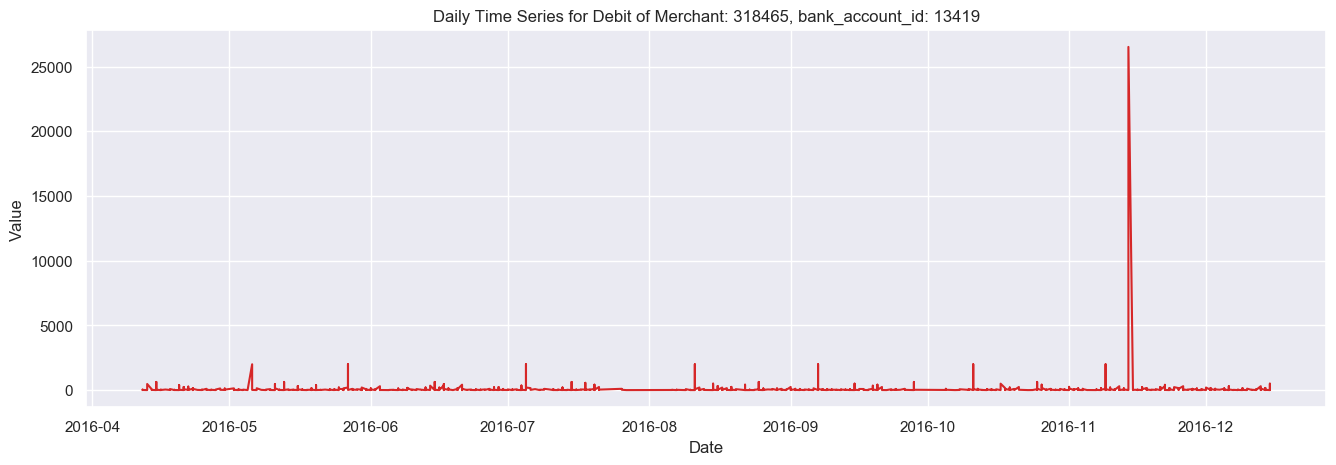

In [29]:
def plot_df(df4, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df4, x=df4.index, y=df4.debit, title='Daily Time Series for Debit of Merchant: 318465, bank_account_id: 13419')


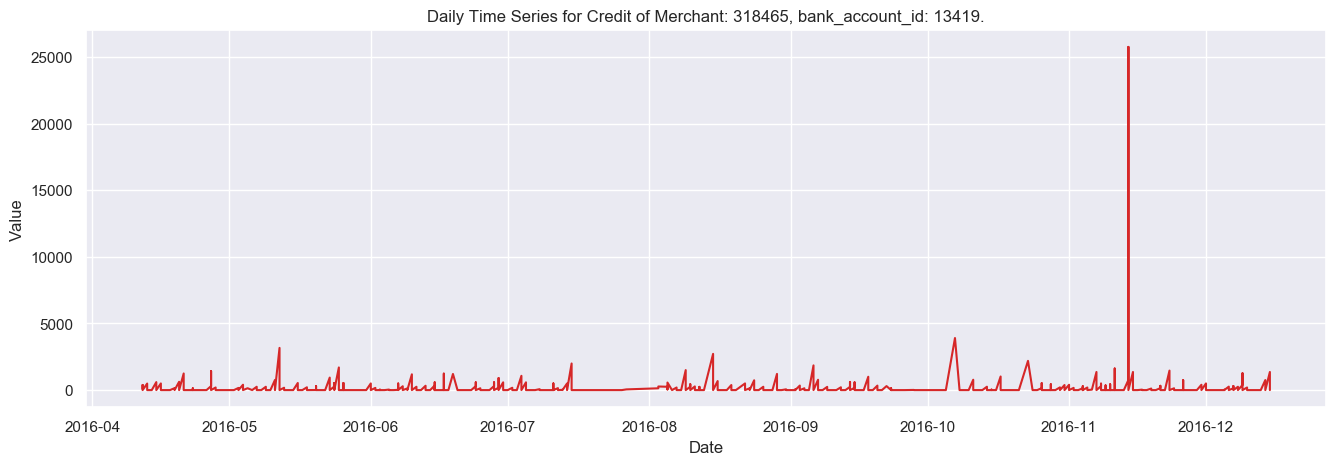

In [30]:
def plot_df(df4, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df4, x=df4.index, y=df4.credit, title='Daily Time Series for Credit of Merchant: 318465, bank_account_id: 13419.')


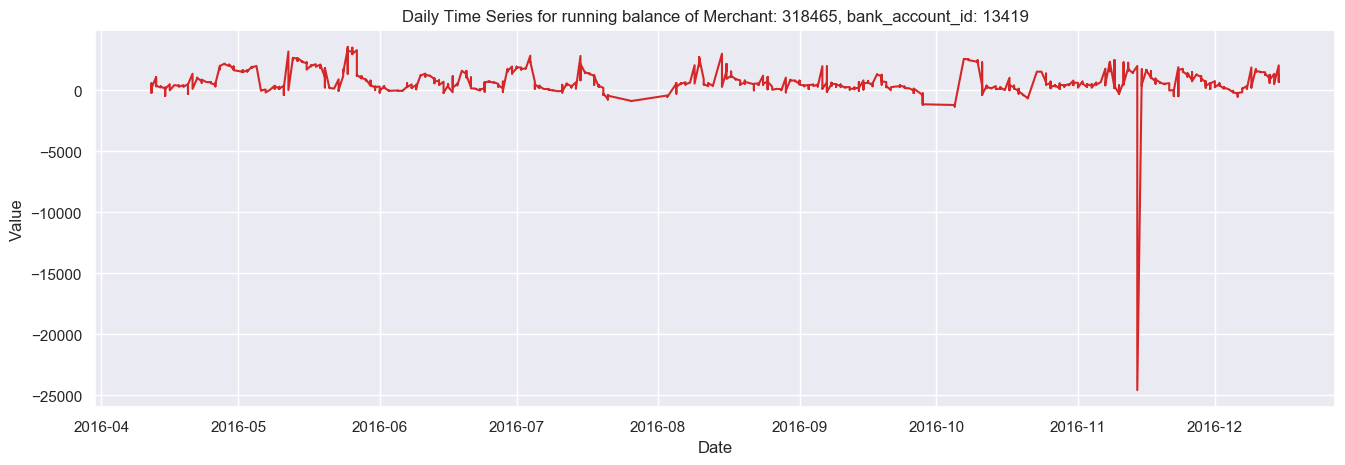

In [31]:
def plot_df(df4, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df4, x=df4.index, y=df4.running_balance, title='Daily Time Series for running balance of Merchant: 318465, bank_account_id: 13419')


### 2.2 Do the same for Lead ID: 326062, bank_account_id : 14046

In [32]:
df5 = df2.loc[(df2['lead_id'] == 326062) & (df2['bank_account_id'] == 14046),['post_date','debit','credit','running_balance']] 
df6 = df5.set_index('post_date')
df6.head()

debit   credit  running_balance
post_date                                   
2016-07-08    0.00  1019.38          1110.16
2016-07-11   30.00     0.00          1125.20
2016-07-11    0.00   500.00          -264.80
2016-07-11    0.00   730.00          1155.20
2016-07-11  290.91     0.00          -362.43

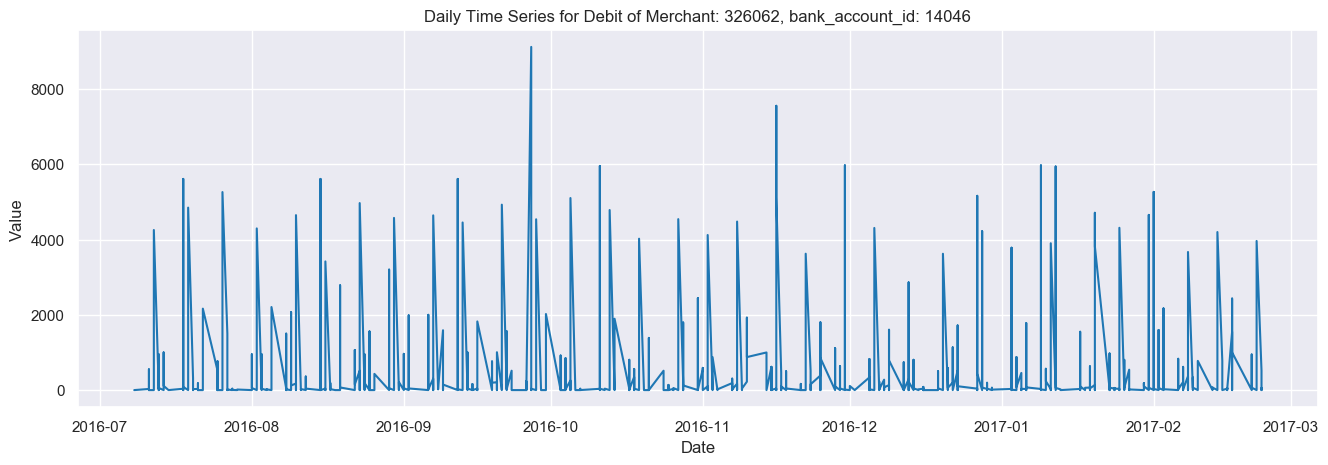

In [33]:
def plot_df(df6, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df6, x=df6.index, y=df6.debit, title='Daily Time Series for Debit of Merchant: 326062, bank_account_id: 14046')


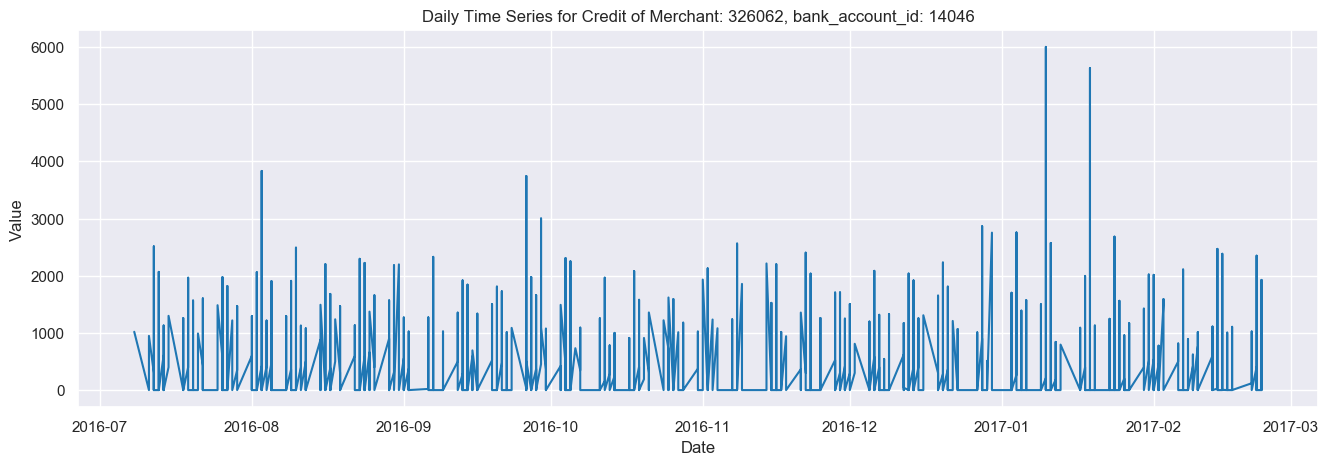

In [34]:
def plot_df(df6, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df6, x=df6.index, y=df6.credit, title='Daily Time Series for Credit of Merchant: 326062, bank_account_id: 14046')


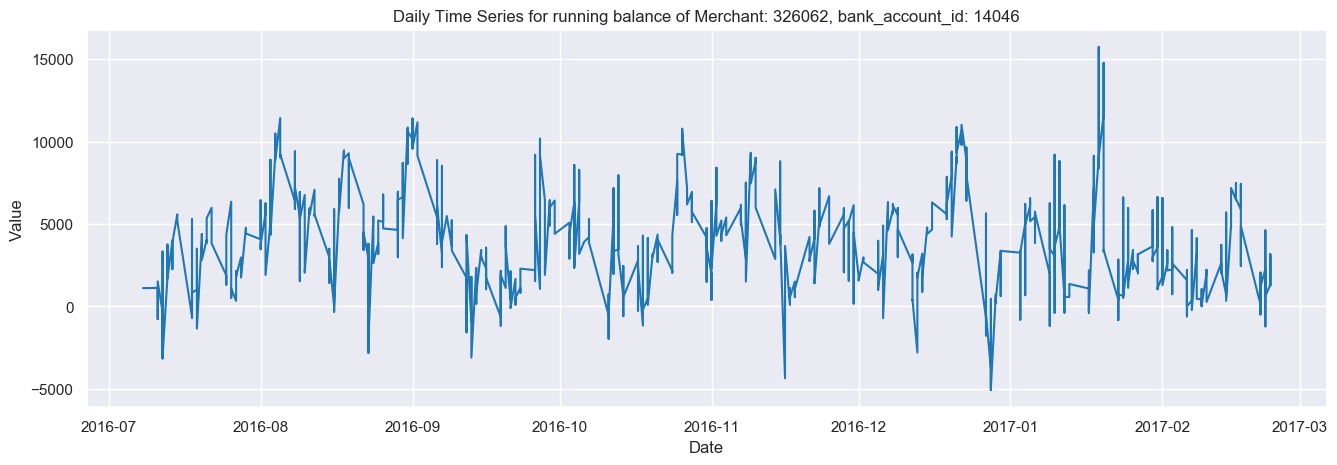

In [35]:
def plot_df(df6, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df6, x=df6.index, y=df6.running_balance, title='Daily Time Series for running balance of Merchant: 326062, bank_account_id: 14046')


### 3. For the merchants with the above Lead IDs, plot the withdrawals, deposits and daily balance as a daily time series (aggregate over all their bank accounts)

### For Merchant Lead ID = 318465

In [36]:
df7 = df2.loc[(df2['lead_id'] == 318465),['post_date','debit','credit','running_balance']] 
df8 = df7.set_index('post_date')
df8.head()

debit  credit  running_balance
post_date                                 
2016-04-12   0.00   87.00           212.52
2016-04-12   0.00  385.00           587.52
2016-04-12   0.00  321.26           125.52
2016-04-12  34.44    0.00          -195.74
2016-04-12  10.00    0.00           202.52

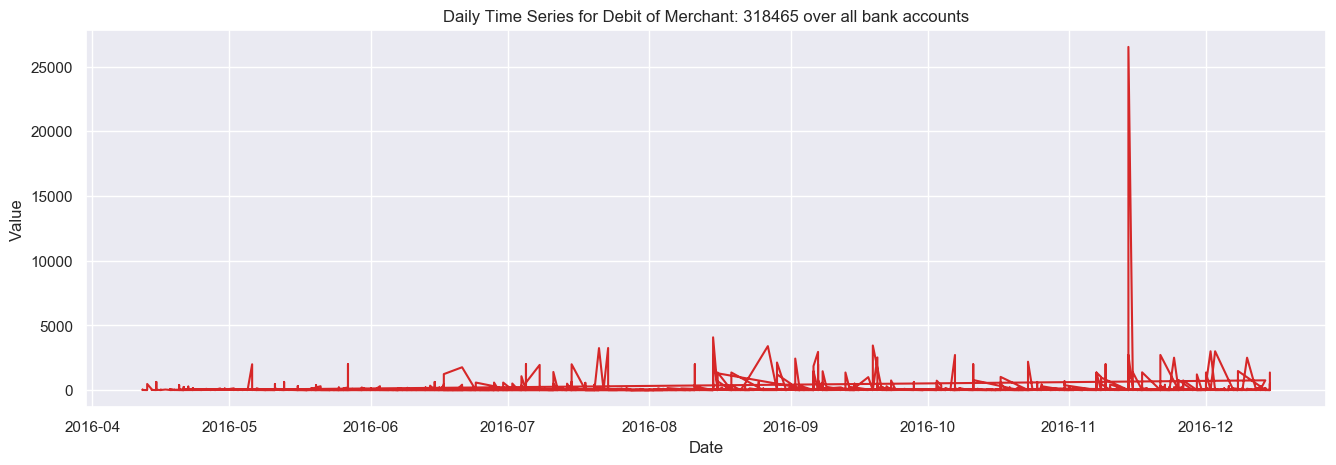

In [37]:
def plot_df(df8, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df8, x=df8.index, y=df8.debit, title='Daily Time Series for Debit of Merchant: 318465 over all bank accounts')


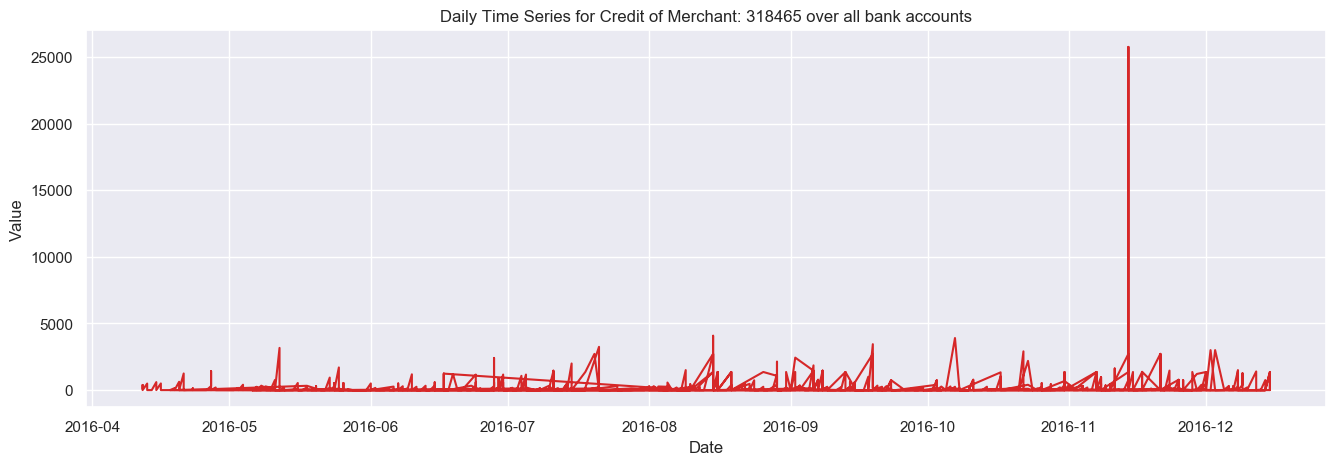

In [38]:
def plot_df(df8, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df8, x=df8.index, y=df8.credit, title='Daily Time Series for Credit of Merchant: 318465 over all bank accounts')


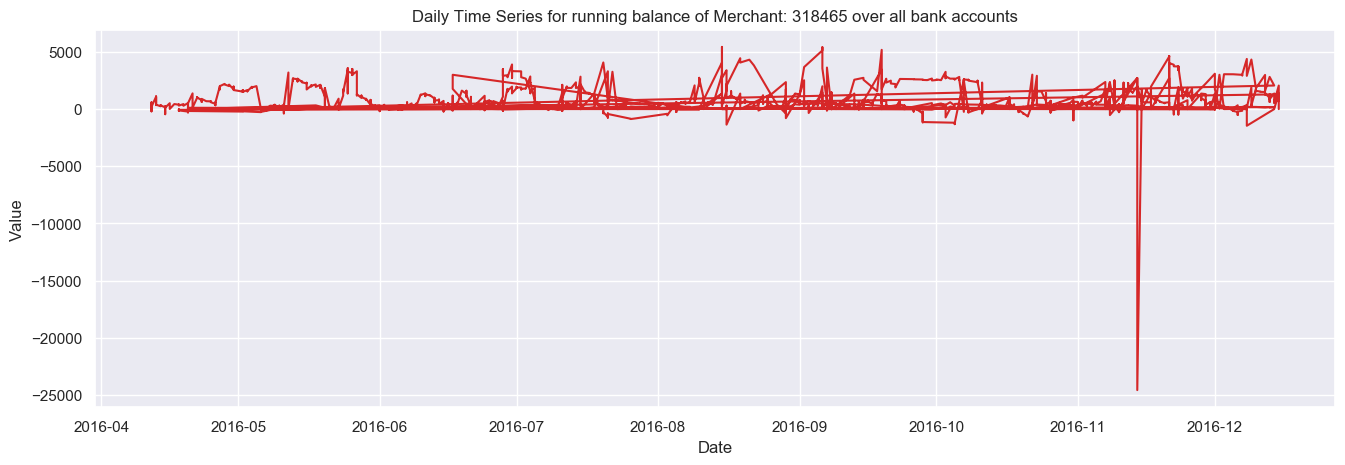

In [39]:
def plot_df(df8, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df8, x=df8.index, y=df8.running_balance, title='Daily Time Series for running balance of Merchant: 318465 over all bank accounts')


### For Merchant Lead ID = 326062

In [40]:
df9 = df2.loc[(df2['lead_id'] == 326062),['post_date','debit','credit','running_balance']] 
df10 = df9.set_index('post_date')
df10.head()

debit   credit  running_balance
post_date                                   
2016-04-13    0.00  1654.57          9829.82
2016-04-13  500.00     0.00          8175.25
2016-04-14    0.00  1028.15          6516.86
2016-04-14   94.93     0.00          6421.93
2016-04-14   71.86     0.00          9757.96

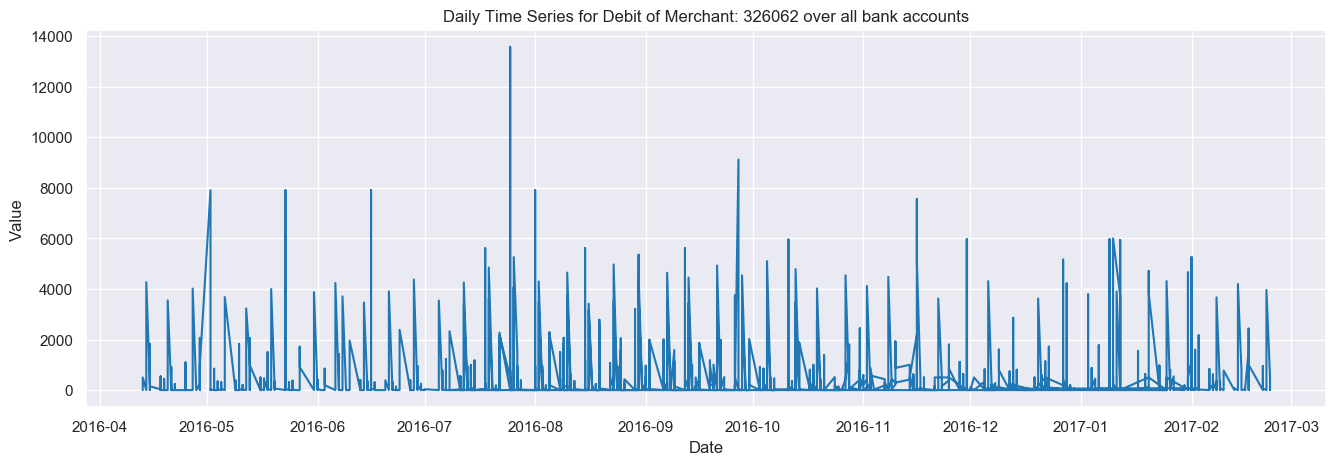

In [41]:
def plot_df(df10, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df10, x=df10.index, y=df10.debit, title='Daily Time Series for Debit of Merchant: 326062 over all bank accounts')


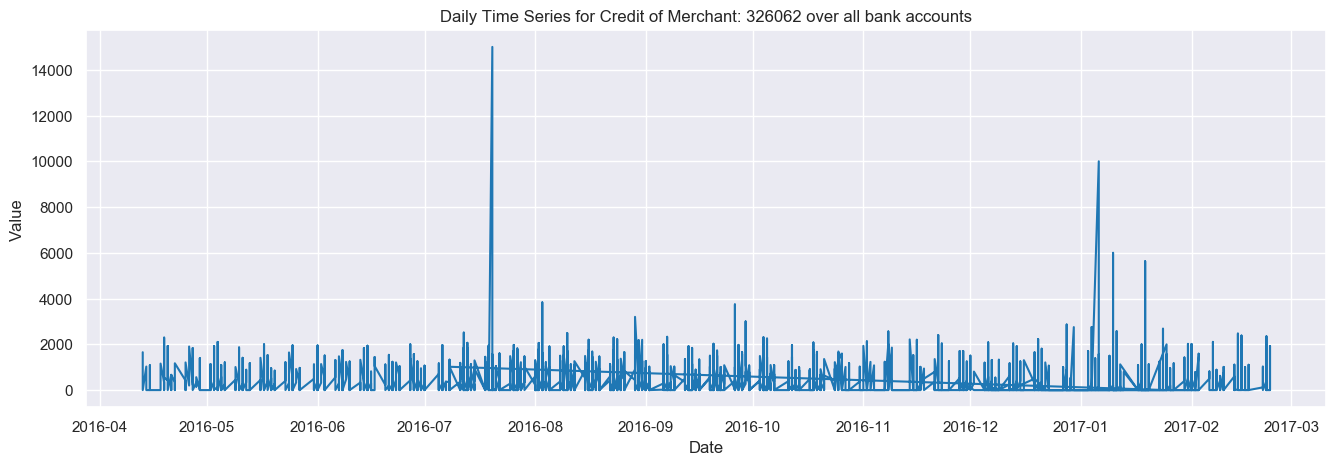

In [42]:
def plot_df(df10, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df10, x=df10.index, y=df10.credit, title='Daily Time Series for Credit of Merchant: 326062 over all bank accounts')


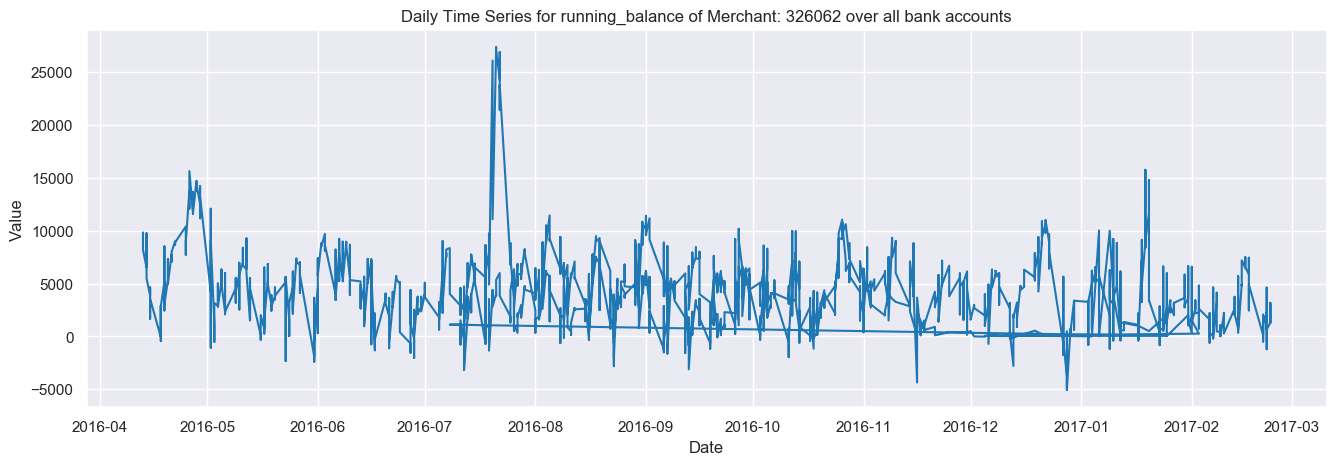

In [43]:
def plot_df(df10, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df10, x=df10.index, y=df10.running_balance, title='Daily Time Series for running_balance of Merchant: 326062 over all bank accounts')

### 4. The cash flow of a business has many dimensions [for example, top 5 deposits/Total deposits,  average # of days between two withdrawals, coefficient of variation of the daily balance] that are potentially relevant to a borrower’s ability to repay. Can you obtain the value of these variables for each merchant? What other cash flow variables can you hypothesize that could be relevant for predicting merchant default?

### Top5 Deposit/ Total Deposit

In [44]:
df_temp = pd.DataFrame(df2.groupby('lead_id').apply(lambda x: x.credit.nlargest(5).sum()))
df_temp = df_temp.rename(columns = {0 : "Top5Deposit"})
df_temp

Top5Deposit
lead_id              
308148.0     25511.20
310443.0    197248.99
312745.0    107203.75
313082.0     80839.50
314036.0     75536.99
314559.0     69867.00
316728.0    533308.06
318465.0     40435.95
321146.0     36317.00
321218.0    716266.77
321356.0    170485.00
321380.0    129305.00
321671.0     27816.63
323253.0    205969.46
325142.0    288822.92
325330.0      8618.54
326050.0     38218.17
326062.0     40461.58
328212.0     18325.00
329803.0     81005.16
330698.0    478274.91

In [45]:
df_temp['Total Deposit'] = df2.groupby('lead_id').agg({'credit':'sum'})
df_temp['Top5Deposit/Total Deposit'] = df_temp['Top5Deposit']/df_temp['Total Deposit']
df_temp['% of total no of transactions'] = df2.groupby(['lead_id']).agg({'credit':lambda x: 5/(x != 0).sum()})
df_temp_total = round(df_temp.sort_values(by='Top5Deposit/Total Deposit', ascending=False),3)
df_temp_total[['Top5Deposit/Total Deposit','% of total no of transactions']]

Top5Deposit/Total Deposit  % of total no of transactions
lead_id                                                           
325142.0                      0.611                          0.043
310443.0                      0.607                          0.143
321218.0                      0.496                          0.088
308148.0                      0.383                          0.029
329803.0                      0.370                          0.043
321146.0                      0.343                          0.041
316728.0                      0.217                          0.017
323253.0                      0.211                          0.017
318465.0                      0.174                          0.014
314036.0                      0.169                          0.018
312745.0                      0.149                          0.031
313082.0                      0.148                          0.045
326050.0                      0.133                          0.026
314559.0                      0.132                          0.035
325330.0                      0.104                          0.016
328212.0                      0.103                          0.018
321671.0                      0.089                          0.008
326062.0                      0.048                          0.006
321380.0                      0.048                          0.001
330698.0                      0.044                          0.014
321356.0                      0.042                          0.007

### Average No of days between two withdrawals

In [46]:
df_temp1 = df2[['lead_id', 'post_date', 'debit']]

In [47]:
df_temp2 = pd.DataFrame(df_temp1.sort_values(by='post_date',ascending = True))
df_temp3 = pd.DataFrame(df_temp2.groupby('lead_id')['post_date'].apply(lambda x: x.diff().sum().days))
df_temp4 = df_temp3.rename(columns = {"post_date" : "No of Days"})
df_temp4

No of Days
lead_id             
308148.0         267
310443.0         345
312745.0         364
313082.0         266
314036.0         313
314559.0         340
316728.0         351
318465.0         247
321146.0         235
321218.0         338
321356.0         342
321380.0         354
321671.0         359
323253.0         310
325142.0         214
325330.0         298
326050.0         212
326062.0         316
328212.0         349
329803.0         351
330698.0         344

In [48]:
df_temp5 = pd.DataFrame(df_temp2.groupby('lead_id')['debit'].apply(lambda x: (x != 0).sum()))
df_temp6 = df_temp5.rename(columns = {'debit' : "No of withdrawals"})
df_temp6['Avg no of days between withdrawals'] = (df_temp4['No of Days']/ df_temp6['No of withdrawals']).apply(np.ceil)
df_temp6[['Avg no of days between withdrawals']]

Avg no of days between withdrawals
lead_id                                     
308148.0                                 1.0
310443.0                                 2.0
312745.0                                 1.0
313082.0                                 1.0
314036.0                                 1.0
314559.0                                 2.0
316728.0                                 1.0
318465.0                                 1.0
321146.0                                 1.0
321218.0                                 1.0
321356.0                                 1.0
321380.0                                 1.0
321671.0                                 1.0
323253.0                                 1.0
325142.0                                 1.0
325330.0                                 2.0
326050.0                                 1.0
326062.0                                 1.0
328212.0                                 2.0
329803.0                                 1.0
330698.0                                 1.0

### Coefficient of variation of the daily balance

In [49]:
df_cov = round(pd.DataFrame(df2.groupby(['lead_id'])['running_balance'].std()/df2.groupby(['lead_id'])['running_balance'].mean()),2)
df_cov.columns.values[0] = 'Coefficient of Variation'
df_cov

Coefficient of Variation
lead_id                           
308148.0                      0.90
310443.0                      0.90
312745.0                      0.82
313082.0                      1.00
314036.0                      1.09
314559.0                      0.83
316728.0                      1.39
318465.0                      1.41
321146.0                     19.69
321218.0                      1.16
321356.0                      1.23
321380.0                      1.00
321671.0                      7.17
323253.0                      1.06
325142.0                      0.91
325330.0                      0.59
326050.0                      0.43
326062.0                      0.90
328212.0                      0.98
329803.0                      2.24
330698.0                      1.16

### Debit to Income Ratio

In [50]:
#Calculated Debit/Credit ratio for each merchant ID over the total period.
#Tried taking it monthly but their are many lead_id's which have only debit or credit in many months. This
#makes the outcome incorrect. Hence, took it over all the months.

In [51]:
df_months_v1 = df2.groupby(by='lead_id').agg({'year_month': pd.Series.nunique})

In [52]:
df_v1 = df2.groupby(['lead_id']).agg({'credit':'sum', 'debit':'sum'})
df_dti = pd.DataFrame(df_v1['debit']/df_v1['credit'])

In [53]:
df_dti.rename(columns = {0 : "Debt to Income"})

Debt to Income
lead_id                 
308148.0        0.927769
310443.0        1.066215
312745.0        0.991400
313082.0        1.021666
314036.0        0.970969
314559.0        0.985210
316728.0        0.980846
318465.0        0.990133
321146.0        0.949590
321218.0        1.014980
321356.0        1.010233
321380.0        0.983412
321671.0        0.984154
323253.0        1.014377
325142.0        0.980927
325330.0        0.970580
326050.0        0.941853
326062.0        1.006465
328212.0        0.985486
329803.0        0.969456
330698.0        0.998947

In [54]:
#round(df_dti_1.groupby('lead_id').agg({'Debt to Income':lambda x: x.sum()/(x != 0).sum()}),2)

### 5. Develop a program by which clusters of similar transactions for a merchant can be identified from transaction descriptions and other information

In [55]:
df_cluster = df2.loc[(df2['lead_id'] == 308148),['post_date','description','transaction_type','amount']] 

In [56]:
df_cluster

post_date                                        description  \
0   2016-03-10                           DEPOSIT ID NUMBER xx6836   
1   2016-03-21  ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...   
2   2016-03-21  ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...   
3   2016-03-21               WAL-MART #0880 IRVING TXxx6007 03/20   
4   2016-03-22            CHECK OR SUPPLY ORDERPPD ID: xxxxxx6800   
..         ...                                                ...   
487 2016-12-01  Prime Meridian AJK Cafe Trans#xx2585 CCD ID: x...   
488 2016-12-02                   ARLANS MARKET # SEABROOK TX12/02   
489 2016-12-02  BANKCARD-8779 BTOT DEP xxxxxxxxxxx4599 CCD ID:...   
490 2016-12-02  BANKCARD-8779 MTOT DISC xxxxxxxxxxx4599 CCD ID...   
491 2016-12-02  Prime Meridian AJK Cafe Trans#xx3234 CCD ID: x...   

    transaction_type   amount  
0             credit  5000.00  
1             credit    16.00  
2             credit  1000.00  
3              debit  1015.50  
4              debit    27.62  
..               ...      ...  
487            debit   123.81  
488            debit    22.34  
489           credit    73.19  
490            debit   230.84  
491            debit   123.81  

[492 rows x 4 columns]

In [57]:
#Deleting duplicated headlines
df_cluster[df_cluster['description'].duplicated(keep=False)].sort_values('description').head(8)

post_date                                        description  \
37  2016-05-13        AMAZON MKTPLACE PMTS AMZN.COM/BILL WA 05/12   
35  2016-05-12        AMAZON MKTPLACE PMTS AMZN.COM/BILL WA 05/12   
1   2016-03-21  ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...   
2   2016-03-21  ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...   
274 2016-10-03  ATM CASH DEPOSIT 10/03 1751 W FM646 RD LEAGUE ...   
273 2016-10-03  ATM CASH DEPOSIT 10/03 1751 W FM646 RD LEAGUE ...   
311 2016-10-17  BANKCARD-8779 BTOT DEP xxxxxxxxxxx4599 CCD ID:...   
275 2016-10-03  BANKCARD-8779 BTOT DEP xxxxxxxxxxx4599 CCD ID:...   

    transaction_type   amount  
37             debit   117.96  
35             debit    55.99  
1             credit    16.00  
2             credit  1000.00  
274           credit   220.00  
273           credit    80.00  
311           credit   117.50  
275           credit   201.26

In [58]:
#Deleting the duplicates by description
df_cluster_n = df_cluster.drop_duplicates('description').reset_index(drop=True)

In [59]:
df_cluster_n

post_date                                        description  \
0   2016-03-10                           DEPOSIT ID NUMBER xx6836   
1   2016-03-21  ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...   
2   2016-03-21               WAL-MART #0880 IRVING TXxx6007 03/20   
3   2016-03-22            CHECK OR SUPPLY ORDERPPD ID: xxxxxx6800   
4   2016-03-23              DOLLARTREE LEAGUE CITY TXxx0062 03/23   
..         ...                                                ...   
312 2016-12-01                 CORNER STORE 2584 SEABROOK TX11/29   
313 2016-12-01            MARSHALLS 1425 W BAY A WEBSTER TX 12/01   
314 2016-12-01  Prime Meridian AJK Cafe Trans#xx2585 CCD ID: x...   
315 2016-12-02                   ARLANS MARKET # SEABROOK TX12/02   
316 2016-12-02  Prime Meridian AJK Cafe Trans#xx3234 CCD ID: x...   

    transaction_type   amount  
0             credit  5000.00  
1             credit    16.00  
2              debit  1015.50  
3              debit    27.62  
4              debit     3.24  
..               ...      ...  
312            debit    12.97  
313           credit   122.29  
314            debit   123.81  
315            debit    22.34  
316            debit   123.81  

[317 rows x 4 columns]

In [60]:
df_cluster_n["description"]

0                               DEPOSIT ID NUMBER xx6836
1      ATM CASH DEPOSIT 03/21 2904 N BELT LINE RD IRV...
2                   WAL-MART #0880 IRVING TXxx6007 03/20
3                CHECK OR SUPPLY ORDERPPD ID: xxxxxx6800
4                  DOLLARTREE LEAGUE CITY TXxx0062 03/23
                             ...                        
312                   CORNER STORE 2584 SEABROOK TX11/29
313              MARSHALLS 1425 W BAY A WEBSTER TX 12/01
314    Prime Meridian AJK Cafe Trans#xx2585 CCD ID: x...
315                     ARLANS MARKET # SEABROOK TX12/02
316    Prime Meridian AJK Cafe Trans#xx3234 CCD ID: x...
Name: description, Length: 317, dtype: object

In [61]:
#From the above we can see that we need to convert everything to lowercase, and remove numbers
#Creating function
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# Doing text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z # +_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

[nltk_data] Downloading package stopwords to /Users/sahil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sahil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [62]:
df_cluster_n["description"] = df_cluster_n["description"].apply(clean_text)
df_cluster_n["description"]

0                          deposit id number
1          atm cash deposit belt line rd irv
2                                walmart irv
3                   check suppli orderppd id
4                       dollartre leagu citi
                       ...                  
312                    corner store seabrook
313                      marshal bay webster
314    prime meridian ajk cafe trans# ccd id
315                    arlan market seabrook
316    prime meridian ajk cafe trans# ccd id
Name: description, Length: 317, dtype: object

In [63]:
#Running TF-IDF Vectorizer
# Run TF IDF Vectorizer on the text data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf= True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')
X_train_vc = vectorizer.fit_transform(df_cluster_n["description"])

X_train_new = pd.DataFrame(X_train_vc.toarray(), columns=vectorizer.get_feature_names())

In [64]:
X_train_new

ajk  ajk cafe    arlan  arlan market       atm  atm withdraw   ca  \
0    0.000000  0.000000  0.00000       0.00000  0.000000           0.0  0.0   
1    0.000000  0.000000  0.00000       0.00000  0.669645           0.0  0.0   
2    0.000000  0.000000  0.00000       0.00000  0.000000           0.0  0.0   
3    0.000000  0.000000  0.00000       0.00000  0.000000           0.0  0.0   
4    0.000000  0.000000  0.00000       0.00000  0.000000           0.0  0.0   
..        ...       ...      ...           ...       ...           ...  ...   
312  0.000000  0.000000  0.00000       0.00000  0.000000           0.0  0.0   
313  0.000000  0.000000  0.00000       0.00000  0.000000           0.0  0.0   
314  0.285727  0.285727  0.00000       0.00000  0.000000           0.0  0.0   
315  0.000000  0.000000  0.48938       0.48938  0.000000           0.0  0.0   
316  0.285727  0.285727  0.00000       0.00000  0.000000           0.0  0.0   

     ca houstont      cafe  cafe trans  ...  superc walmart     trans  \
0            0.0  0.000000    0.000000  ...             0.0  0.000000   
1            0.0  0.000000    0.000000  ...             0.0  0.000000   
2            0.0  0.000000    0.000000  ...             0.0  0.000000   
3            0.0  0.000000    0.000000  ...             0.0  0.000000   
4            0.0  0.000000    0.000000  ...             0.0  0.000000   
..           ...       ...         ...  ...             ...       ...   
312          0.0  0.000000    0.000000  ...             0.0  0.000000   
313          0.0  0.000000    0.000000  ...             0.0  0.000000   
314          0.0  0.285727    0.285727  ...             0.0  0.285727   
315          0.0  0.000000    0.000000  ...             0.0  0.000000   
316          0.0  0.285727    0.285727  ...             0.0  0.285727   

     trans ccd  walmart  walmart sup  walmart super  webster  withdraw   wm  \
0     0.000000      0.0          0.0            0.0      0.0       0.0  0.0   
1     0.000000      0.0          0.0            0.0      0.0       0.0  0.0   
2     0.000000      1.0          0.0            0.0      0.0       0.0  0.0   
3     0.000000      0.0          0.0            0.0      0.0       0.0  0.0   
4     0.000000      0.0          0.0            0.0      0.0       0.0  0.0   
..         ...      ...          ...            ...      ...       ...  ...   
312   0.000000      0.0          0.0            0.0      0.0       0.0  0.0   
313   0.000000      0.0          0.0            0.0      1.0       0.0  0.0   
314   0.285727      0.0          0.0            0.0      0.0       0.0  0.0   
315   0.000000      0.0          0.0            0.0      0.0       0.0  0.0   
316   0.285727      0.0          0.0            0.0      0.0       0.0  0.0   

     wm superc  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  
..         ...  
312        0.0  
313        0.0  
314        0.0  
315        0.0  
316        0.0  

[317 rows x 57 columns]

In [65]:
df_pf = pd.concat([df_cluster_n, X_train_new],axis=1)

In [66]:
df_f = pd.get_dummies(df_pf,columns = ['transaction_type'])

In [67]:
df_z = df_f.drop(['description','post_date'], axis=1)

In [68]:
df_z

amount       ajk  ajk cafe    arlan  arlan market       atm  \
0    5000.00  0.000000  0.000000  0.00000       0.00000  0.000000   
1      16.00  0.000000  0.000000  0.00000       0.00000  0.669645   
2    1015.50  0.000000  0.000000  0.00000       0.00000  0.000000   
3      27.62  0.000000  0.000000  0.00000       0.00000  0.000000   
4       3.24  0.000000  0.000000  0.00000       0.00000  0.000000   
..       ...       ...       ...      ...           ...       ...   
312    12.97  0.000000  0.000000  0.00000       0.00000  0.000000   
313   122.29  0.000000  0.000000  0.00000       0.00000  0.000000   
314   123.81  0.285727  0.285727  0.00000       0.00000  0.000000   
315    22.34  0.000000  0.000000  0.48938       0.48938  0.000000   
316   123.81  0.285727  0.285727  0.00000       0.00000  0.000000   

     atm withdraw   ca  ca houstont      cafe  ...  trans ccd  walmart  \
0             0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
1             0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
2             0.0  0.0          0.0  0.000000  ...   0.000000      1.0   
3             0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
4             0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
..            ...  ...          ...       ...  ...        ...      ...   
312           0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
313           0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
314           0.0  0.0          0.0  0.285727  ...   0.285727      0.0   
315           0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
316           0.0  0.0          0.0  0.285727  ...   0.285727      0.0   

     walmart sup  walmart super  webster  withdraw   wm  wm superc  \
0            0.0            0.0      0.0       0.0  0.0        0.0   
1            0.0            0.0      0.0       0.0  0.0        0.0   
2            0.0            0.0      0.0       0.0  0.0        0.0   
3            0.0            0.0      0.0       0.0  0.0        0.0   
4            0.0            0.0      0.0       0.0  0.0        0.0   
..           ...            ...      ...       ...  ...        ...   
312          0.0            0.0      0.0       0.0  0.0        0.0   
313          0.0            0.0      1.0       0.0  0.0        0.0   
314          0.0            0.0      0.0       0.0  0.0        0.0   
315          0.0            0.0      0.0       0.0  0.0        0.0   
316          0.0            0.0      0.0       0.0  0.0        0.0   

     transaction_type_credit  transaction_type_debit  
0                          1                       0  
1                          1                       0  
2                          0                       1  
3                          0                       1  
4                          0                       1  
..                       ...                     ...  
312                        0                       1  
313                        1                       0  
314                        0                       1  
315                        0                       1  
316                        0                       1  

[317 rows x 60 columns]

In [69]:
df_zz = df_z.copy()

In [70]:
#Trying kprototypes to check the no of clusters
model = kmodes.kprototypes.KPrototypes(n_clusters = 3,init = 'Huang',verbose = 1)

clusters = model.fit_predict(df_zz,categorical = list(range(1, df_zz.shape[1]))) # Index of columns that contain categorical data. All columns in the dataframe except the first.


# Insert the clusters into the dataframe.
df_zz = df_zz.assign(Cluster = pd.Series(clusters).values)

# Print the clusters and their transactions.
for cluster, cluster_data_frame in df_zz.groupby('Cluster'):
  print('Cluster: ' + str(cluster))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 185, ncost: 106828898.88864206
Run: 1, iteration: 2/100, moves: 59, ncost: 58620446.94598173
Run: 1, iteration: 3/100, moves: 18, ncost: 56542999.27981728
Run: 1, iteration: 4/100, moves: 6, ncost: 56437348.58498492
Run: 1, iteration: 5/100, moves: 0, ncost: 56437348.58498492
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 39, ncost: 61826840.41863122
Run: 2, iteration: 2/100, moves: 18, ncost: 56542999.27981729
Run: 2, iteration: 3/100, moves: 6, ncost: 56437348.58498492
Run: 2, iteration: 4/100, moves: 0, ncost: 56437348.58498492
Init: initializing centroids
Init: initializing clusters

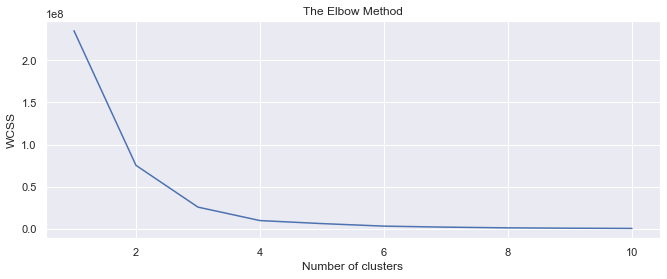

In [71]:
k_clusters = 10

from sklearn.cluster import KMeans

score = []
for i in range(1,k_clusters + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
    kmeans.fit(df_z)
    score.append(kmeans.inertia_)
plt.plot(range(1,k_clusters + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.savefig('elbow.png')
plt.show()

In [72]:
df_z2 = df_z.copy()
kmeans_scale = KMeans(n_clusters=3, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(df_z2)
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(df_z2, kmeans_scale.labels_, metric='euclidean')))
labels_scale = kmeans_scale.labels_
clusters_scale = pd.concat([df_z2, pd.DataFrame({'cluster_scaled':labels_scale})], axis=1)

KMeans Scaled Silhouette Score: 0.92704106607427


In [73]:
df_zz.groupby('Cluster').agg({'amount':['mean','count']}).round(2)

amount      
            mean count
Cluster               
0        5396.53     6
1         832.81    38
2          86.30   273

In [74]:
#clusters_scale.groupby('cluster_scaled').agg({'amount':['mean','count']}).round(2)

In [75]:
df_z2.head()

amount  ajk  ajk cafe  arlan  arlan market       atm  atm withdraw   ca  \
0  5000.00  0.0       0.0    0.0           0.0  0.000000           0.0  0.0   
1    16.00  0.0       0.0    0.0           0.0  0.669645           0.0  0.0   
2  1015.50  0.0       0.0    0.0           0.0  0.000000           0.0  0.0   
3    27.62  0.0       0.0    0.0           0.0  0.000000           0.0  0.0   
4     3.24  0.0       0.0    0.0           0.0  0.000000           0.0  0.0   

   ca houstont  cafe  ...  trans ccd  walmart  walmart sup  walmart super  \
0          0.0   0.0  ...        0.0      0.0          0.0            0.0   
1          0.0   0.0  ...        0.0      0.0          0.0            0.0   
2          0.0   0.0  ...        0.0      1.0          0.0            0.0   
3          0.0   0.0  ...        0.0      0.0          0.0            0.0   
4          0.0   0.0  ...        0.0      0.0          0.0            0.0   

   webster  withdraw   wm  wm superc  transaction_type_credit  \
0      0.0       0.0  0.0        0.0                        1   
1      0.0       0.0  0.0        0.0                        1   
2      0.0       0.0  0.0        0.0                        0   
3      0.0       0.0  0.0        0.0                        0   
4      0.0       0.0  0.0        0.0                        0   

   transaction_type_debit  
0                       0  
1                       0  
2                       1  
3                       1  
4                       1  

[5 rows x 60 columns]

In [76]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_z2['amount'] = scaler.fit_transform(df_z2['amount'].values.reshape(-1,1)) 
df_z2 = pd.DataFrame(df_z2, columns=df_z2.columns)
df_z2
#scaler = StandardScaler()
#scaler.fit(df_z2)
#X_scale = scaler.transform(df_z2)
#df_scale = pd.DataFrame(X_scale, columns=df.columns)
#df_scale.head()

amount       ajk  ajk cafe    arlan  arlan market       atm  \
0    0.434310  0.000000  0.000000  0.00000       0.00000  0.000000   
1    0.001303  0.000000  0.000000  0.00000       0.00000  0.669645   
2    0.088139  0.000000  0.000000  0.00000       0.00000  0.000000   
3    0.002313  0.000000  0.000000  0.00000       0.00000  0.000000   
4    0.000195  0.000000  0.000000  0.00000       0.00000  0.000000   
..        ...       ...       ...      ...           ...       ...   
312  0.001040  0.000000  0.000000  0.00000       0.00000  0.000000   
313  0.010538  0.000000  0.000000  0.00000       0.00000  0.000000   
314  0.010670  0.285727  0.285727  0.00000       0.00000  0.000000   
315  0.001854  0.000000  0.000000  0.48938       0.48938  0.000000   
316  0.010670  0.285727  0.285727  0.00000       0.00000  0.000000   

     atm withdraw   ca  ca houstont      cafe  ...  trans ccd  walmart  \
0             0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
1             0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
2             0.0  0.0          0.0  0.000000  ...   0.000000      1.0   
3             0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
4             0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
..            ...  ...          ...       ...  ...        ...      ...   
312           0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
313           0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
314           0.0  0.0          0.0  0.285727  ...   0.285727      0.0   
315           0.0  0.0          0.0  0.000000  ...   0.000000      0.0   
316           0.0  0.0          0.0  0.285727  ...   0.285727      0.0   

     walmart sup  walmart super  webster  withdraw   wm  wm superc  \
0            0.0            0.0      0.0       0.0  0.0        0.0   
1            0.0            0.0      0.0       0.0  0.0        0.0   
2            0.0            0.0      0.0       0.0  0.0        0.0   
3            0.0            0.0      0.0       0.0  0.0        0.0   
4            0.0            0.0      0.0       0.0  0.0        0.0   
..           ...            ...      ...       ...  ...        ...   
312          0.0            0.0      0.0       0.0  0.0        0.0   
313          0.0            0.0      1.0       0.0  0.0        0.0   
314          0.0            0.0      0.0       0.0  0.0        0.0   
315          0.0            0.0      0.0       0.0  0.0        0.0   
316          0.0            0.0      0.0       0.0  0.0        0.0   

     transaction_type_credit  transaction_type_debit  
0                          1                       0  
1                          1                       0  
2                          0                       1  
3                          0                       1  
4                          0                       1  
..                       ...                     ...  
312                        0                       1  
313                        1                       0  
314                        0                       1  
315                        0                       1  
316                        0                       1  

[317 rows x 60 columns]

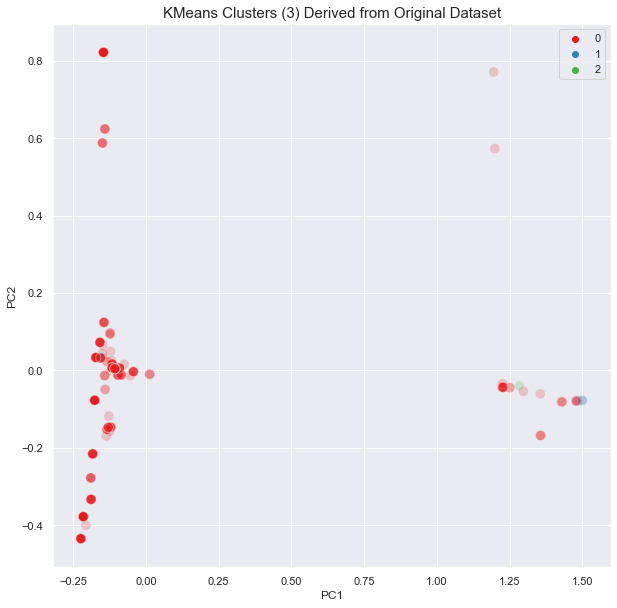

In [77]:
###Using PCA
pca2 = PCA(n_components=3).fit(df_z2)
pca2d = pca2.transform(df_z2)
plt.figure(figsize = (10,10))
sns.scatterplot(pca2d[:,0], pca2d[:,1], 
                hue=labels_scale, 
                palette='Set1',
                s=100, alpha=0.2).set_title('KMeans Clusters (3) Derived from Original Dataset', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()

In [78]:
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
import plotly.express as px

In [79]:
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = labels_scale
trace = go.Scatter3d(x=pca2d[:,0], y=pca2d[:,1], z=pca2d[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(margin=dict(l=0,r=0),scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.show()

In [80]:
pca = PCA(n_components=3)
pca_scale = pca.fit_transform(df_z)
pca_df_z = pd.DataFrame(pca_scale, columns=['pc1','pc2','pc3'])
print(pca.explained_variance_ratio_)

[9.99998734e-01 2.32538618e-07 1.12267666e-07]


[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 317 samples in 0.001s...
[t-SNE] Computed neighbors for 317 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 317 / 317
[t-SNE] Mean sigma: 0.687051
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.389755
[t-SNE] KL divergence after 5000 iterations: 1.442946


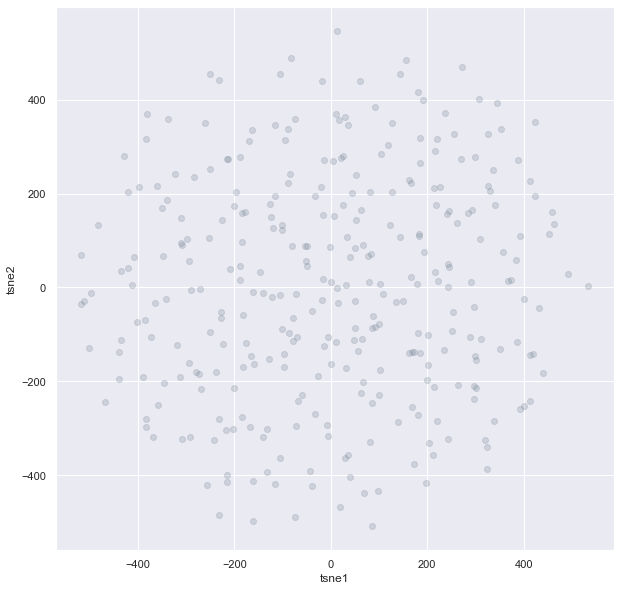

In [81]:
tsne = TSNE(n_components=3, verbose=1, perplexity=80, n_iter=5000, learning_rate=200)
tsne_scale_results = tsne.fit_transform(df_z2)
tsne_df_scale = pd.DataFrame(tsne_scale_results, columns=['tsne1', 'tsne2', 'tsne3'])
plt.figure(figsize = (10,10))
plt.scatter(tsne_df_scale.iloc[:,0],tsne_df_scale.iloc[:,1],alpha=0.25, facecolor='lightslategray')
plt.xlabel('tsne1')
plt.ylabel('tsne2')
plt.show()

Text(0, 0.5, 'Inertia')

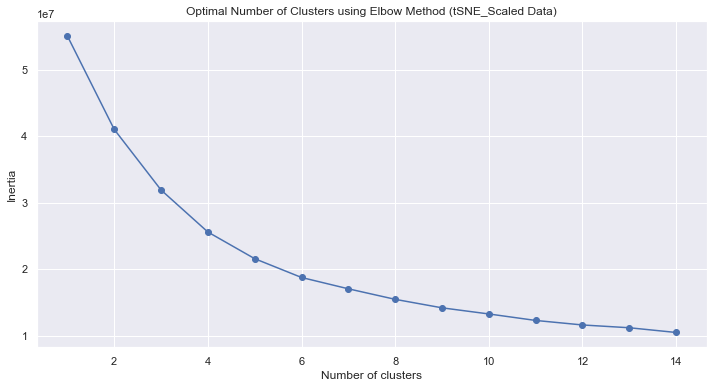

In [82]:
sse = []
k_list = range(1, 15)
for k in k_list:
    km = KMeans(n_clusters=k)
    km.fit(tsne_df_scale)
    sse.append([k, km.inertia_])
    
tsne_results_scale = pd.DataFrame({'Cluster': range(1,15), 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o')
plt.title('Optimal Number of Clusters using Elbow Method (tSNE_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [83]:
kmeans_tsne_scale = KMeans(n_clusters=3, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df_scale)
print('KMeans tSNE Scaled Silhouette Score: {}'.format(silhouette_score(tsne_df_scale, kmeans_tsne_scale.labels_, metric='euclidean')))
labels_tsne_scale = kmeans_tsne_scale.labels_
clusters_tsne_scale = pd.concat([tsne_df_scale, pd.DataFrame({'tsne_clusters':labels_tsne_scale})], axis=1)

KMeans tSNE Scaled Silhouette Score: 0.24596287310123444


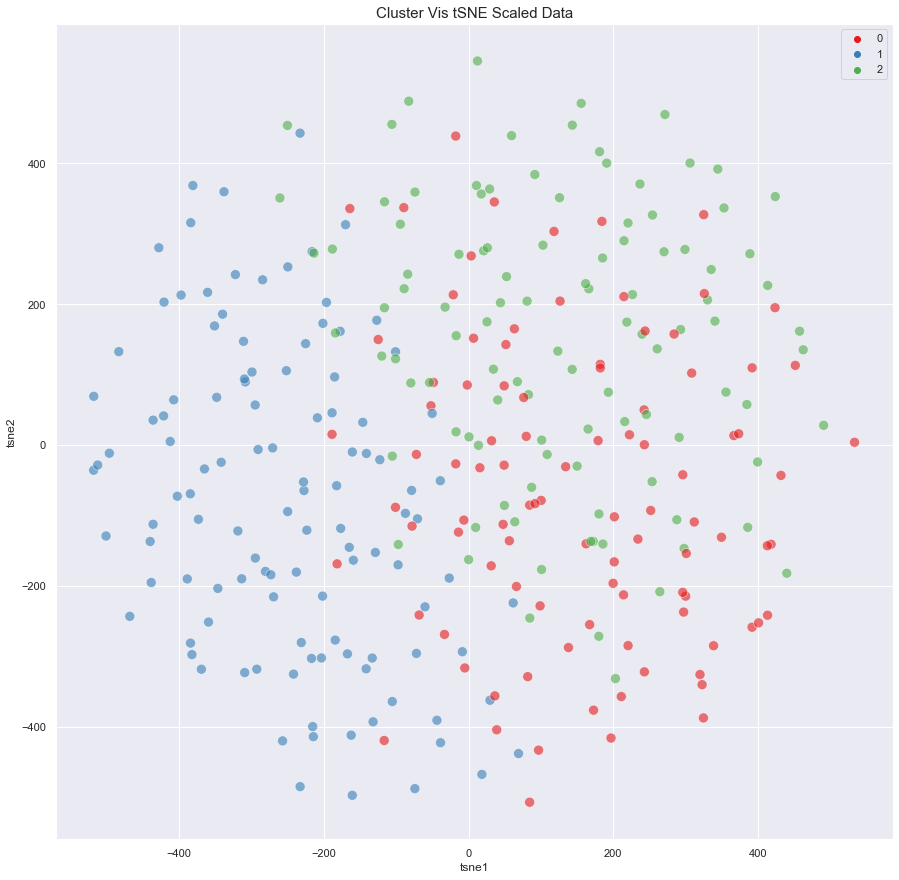

In [84]:
plt.figure(figsize = (15,15))
sns.scatterplot(clusters_tsne_scale.iloc[:,0],clusters_tsne_scale.iloc[:,1],hue=labels_tsne_scale, palette='Set1', s=100, alpha=0.6).set_title('Cluster Vis tSNE Scaled Data', fontsize=15)
plt.legend()
plt.show()